In [3]:
import osmnx as ox
import math
import heapq
import matplotlib.pyplot as plt
import networkx as nx

Load Map

In [4]:
city = "Nador, Morocco"
G = ox.graph_from_place(city, network_type="drive")

In [5]:
num_nodes = len(G.nodes)
print("Nombre de nœuds dans le graphe :", num_nodes)

Nombre de nœuds dans le graphe : 5602


Coordinates of start and destination nodes

In [6]:
#start and destination nodes in GPS
start_node_y, start_node_x=35.1686165, -2.9275836#centre ville
dest_node_y, dest_node_x=35.173000 ,-2.926000 #hopital Laari Cheikh

#Nodes=Intersections & edges=roads & y=latitude & x=longitude
start_node = ox.distance.nearest_nodes(G, X=start_node_x, Y=start_node_y) #calculate distance from input coordiantes(start_node_x,start_node_y) to evry node in graph G then select node with minimum distance
dest_node = ox.distance.nearest_nodes(G, X=dest_node_x, Y=dest_node_y)

#all paths from start to destination
all_paths = list(nx.all_simple_paths(G, source=start_node, target=dest_node, cutoff=17))


Implementation of A*

In [25]:
#Calcule de l'heuritique en utilisant distance euclidienne, heuristique c'est la distance entre un noeud n et la destination
def heuristic(node1,node2,G):#on utilisant distance euclidienne
    x1,y1=G.nodes[node1]['x'], G.nodes[node1]['y']#get coordiantes (x,y) du node1 
    x2,y2=G.nodes[node2]['x'], G.nodes[node2]['y']#get coordiantes (x,y) du node2
    results= round(math.sqrt((x2 - x1)**2 + (y2 - y1)**2),2)#get 2 values after virgule
    return results

#Fonction cout=temps estime entre 2 noeuds u et v
def temps_estimated(u,v,G,alpha=0.7, beta=0.3):
    data = G.get_edge_data(u,v,0)#information sur route(edge) entre u et v
    distance = data.get("length",1)/1000 #distance of edge cad entre u et v en km(cause de la division par 1000)
    traffic = data.get("traffic",20) #default value du traffic est 20
    return alpha*distance + beta*traffic

#Total cost
def temps_total(path, G, alpha=0.7, beta=0.3):
    total_time = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        total_time += temps_estimated(u, v, G, alpha, beta)
    return total_time

#A* function
def a_star(G, start, dest, alpha=0.7, beta=0.3):
    open_set=[] #priority queue(min-heap), heap is a tree where top node has smallest or largest values, it store nodes to explore next
    heapq.heappush(open_set, (0,start))#insert start node into priority queue with cost of 0

    came_from = {} #storing parent of of each visited node so we keep track of the optimal path
    g_score = {node: float('inf') for node in G.nodes}#g_cost is cost from initial node to node n, we initialise g_cost of all nodes with infinite cost cz we still didn't reach them all 
    g_score[start] = 0 #g_cost of initial node is 0
    f_score={node: float('inf') for node in G.nodes}#f_score=g+h is total estimated cost to reach destination : start node->current node->destination node; it is initially initialised by infinite value
    f_score[start]=heuristic(start,dest,G)#f=g+h and g=0 for start node so f=g

    #loop to explore nodes still not visited
    while open_set: 
        _,current = heapq.heappop(open_set)#select current node with lowest cost cz we are using min-heap and pop it(remove it)
        #check if goal is reached
        if current == dest:
            path = []#nodes that form optimal route from destination back to start (we are working with a tree)
            while current in came_from:
                path.append(current)#reconstruct path by backtracking from destination to start using came_from dict 
                current = came_from[current]
            path.append(start)#after end of loop start node also is added to path
            return path[::-1]#return reversed path bzc path stored from destination to start so now we need reslt to be from start to destination
        #exploring neighbor nodes of current node
        for neighbor in G.neighbors(current):
            tentative_g_score = g_score[current]+temps_estimated(current,neighbor,G, alpha,beta) #tentative g cost to reach neighbor
            if tentative_g_score < g_score[neighbor]:#if new tentative cost < g cost of neighbor then we found a better path 
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic(neighbor, dest, G)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None

optimal_path = a_star(G, start_node, dest_node)
total_estimated_time = temps_total(optimal_path, G)

if optimal_path:
    print("Optimal path:", optimal_path)
    print("Temps total estimé :", total_estimated_time)

else:
    print("No path found!")



Optimal path: [359187007, 5720434617, 5620534295, 1892664265, 5720454258, 5720462285, 5720462284, 5720462280, 5720474735, 359191092, 359190659, 1784918407, 1785470206, 1785468821, 1784918008]
Temps total estimé : 84.41071263611946


In [26]:
import folium
import networkx as nx

if optimal_path:
    route_map = folium.Map(location=[(start_node_y + dest_node_y) / 2, (start_node_x + dest_node_x) / 2], zoom_start=14)
    
    #marker for all nodes in optimal path
    for node in optimal_path:
        folium.CircleMarker(location=(G.nodes[node]['y'], G.nodes[node]['x']),radius=5,color='green',fill=True,fill_opacity=0.7).add_to(route_map)
    
    #marker for start and destination node
    folium.Marker(location=[G.nodes[start_node]['y'], G.nodes[start_node]['x']],popup="Nœud de depart: Centre Ville",icon=folium.Icon(color='blue', icon='info-sign')).add_to(route_map)
    folium.Marker(location=[G.nodes[dest_node]['y'], G.nodes[dest_node]['x']],popup="Nœud d'arrivee: Hopital Laari Cheikh",icon=folium.Icon(color='blue', icon='info-sign')).add_to(route_map)

    route_edges = []
    for i in range(len(optimal_path) - 1):
        u, v = optimal_path[i], optimal_path[i+1]
        edge_geom = ox.graph_to_gdfs(G.subgraph([u, v]), nodes=False)['geometry'].values
        route_edges.extend(edge_geom)

    for edge in route_edges:
        folium.PolyLine([(point[1], point[0]) for point in edge.coords], color='red', weight=5).add_to(route_map)
    
else:
    print("no optimal path found")

route_map

In [27]:
for idx, path in enumerate(all_paths):  
    path_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]
    folium.PolyLine(path_coords, color='blue', weight=4, opacity=0.8).add_to(route_map)
route_map

Test avec un sous-graphe de 1000 nœuds...
Taille du sous-graphe : 1000 | Temps d'execution : 0.0000 secondes
Test avec un sous-graphe de 2000 nœuds...
Taille du sous-graphe : 2000 | Temps d'execution : 0.0000 secondes
Test avec un sous-graphe de 3000 nœuds...
Taille du sous-graphe : 3000 | Temps d'execution : 0.0000 secondes
Test avec un sous-graphe de 3500 nœuds...
Taille du sous-graphe : 3500 | Temps d'execution : 0.0099 secondes
Test avec un sous-graphe de 4000 nœuds...
Taille du sous-graphe : 4000 | Temps d'execution : 0.0076 secondes
Test avec un sous-graphe de 5000 nœuds...
Taille du sous-graphe : 5000 | Temps d'execution : 0.0043 secondes


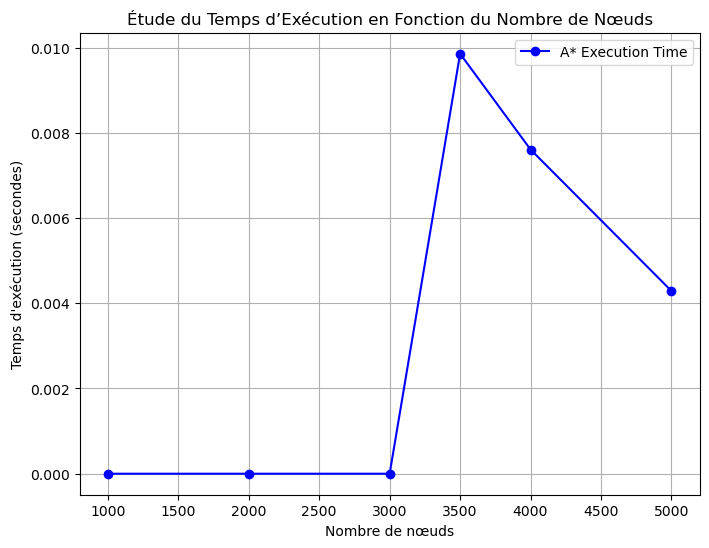

In [28]:
import random
import time

start_node = ox.distance.nearest_nodes(G, X=start_node_x, Y=start_node_y) #calculate distance from input coordiantes(start_node_x,start_node_y) to evry node in graph G then select node with minimum distance
dest_node = ox.distance.nearest_nodes(G, X=dest_node_x, Y=dest_node_y)

sizes = [1000, 2000, 3000, 3500, 4000,5000]#nodes
execution_times = []

for size in sizes:
    print(f"Test avec un sous-graphe de {size} nœuds...")
    #Sous-graphe alratoire
    nodes = list(G.nodes)[:size]
    sub_nodes = random.sample(nodes, min(size, len(nodes)))
    sub_G = G.subgraph(sub_nodes).copy()

    #Temps d'execution de A*
    start_time = time.time()
    optimal_path = a_star(sub_G, start_node, dest_node)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    print(f"Taille du sous-graphe : {size} | Temps d'execution : {end_time - start_time:.4f} secondes")

# Supprimer les entrées None pour le tracé du graphique
filtered_sizes = [sizes[i] for i in range(len(sizes)) if execution_times[i] is not None]
filtered_times = [t for t in execution_times if t is not None]

plt.figure(figsize=(8, 6))
plt.plot(filtered_sizes, filtered_times, marker='o', linestyle='-', color='b', label='A* Execution Time')
plt.xlabel('Nombre de nœuds')
plt.ylabel('Temps d\'exécution (secondes)')
plt.title('Étude du Temps d’Exécution en Fonction du Nombre de Nœuds')
plt.legend()
plt.grid(True)
plt.show()

Implementation du PSO


Choisir sub graph avec 2km de distance

In [29]:
sub_graph = ox.truncate.truncate_graph_dist(G, source_node=start_node, dist=2000)#2km
print(len(sub_graph.nodes))

2891


In [37]:
# Paramètres de la fonction de coût
alpha = 0.7  # Importance de la distance
beta = 0.3   # Importance du trafic

#Fonction de cout
def cost_function(path):
    total_time = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if sub_G.has_edge(u, v):
            distance = sub_G.edges[u, v, 0].get('length', 1) / 1000  # Distance en km
            traffic = sub_G.edges[u, v, 0].get('traffic', 20)  # Trafic par défaut
            total_time += alpha * distance + beta * traffic
        else:
            return float('inf')  
    return total_time

#Initialisation des particules
def initialize_particles(num_particles, optimal_path):
    particles = []
    for _ in range(num_particles):
        perturbated_path = optimal_path[:] #Perturber chemin optimal
        random.shuffle(perturbated_path[1:-1])
        particles.append(perturbated_path)
    return particles

# Mise à jour des particules
def update_particle(particle, g_best_path):
    crossover_point = random.randint(1, len(particle) - 2)
    new_path = particle[:crossover_point] + g_best_path[crossover_point:]
    return new_path

# PSO pour la recherche du chemin optimal
def pso_path_finding(sub_G, optimal_path, num_particles=10, max_iter=50):
    particles = initialize_particles(num_particles, optimal_path)
    g_best_path = None
    g_best_cost = float('inf')

    for iteration in range(max_iter):
        for i in range(num_particles):
            particle = particles[i]
            cost = cost_function(particle)

            # Mettre à jour le meilleur chemin global
            if cost < g_best_cost:
                g_best_path = particle
                g_best_cost = cost

            # Mise à jour de la particule
            particles[i] = update_particle(particle, g_best_path)

        print(f"Iteration {iteration + 1}/{max_iter}, meilleur coût : {g_best_cost}")

    return g_best_path, g_best_cost

# Lancer PSO
optimal_path_a_star = optimal_path
optimal_path, optimal_cost = pso_path_finding(sub_G, optimal_path_a_star)

# Résultat
print("Chemin optimal trouvé :", optimal_path)
print("Coût total du chemin :", optimal_cost)


Iteration 1/50, meilleur coût : 102.55522412937694
Iteration 2/50, meilleur coût : 102.55522412937694
Iteration 3/50, meilleur coût : 102.55522412937694
Iteration 4/50, meilleur coût : 102.55522412937694
Iteration 5/50, meilleur coût : 102.55522412937694
Iteration 6/50, meilleur coût : 102.55522412937694
Iteration 7/50, meilleur coût : 102.55522412937694
Iteration 8/50, meilleur coût : 102.55522412937694
Iteration 9/50, meilleur coût : 102.55522412937694
Iteration 10/50, meilleur coût : 102.55522412937694
Iteration 11/50, meilleur coût : 102.55522412937694
Iteration 12/50, meilleur coût : 102.55522412937694
Iteration 13/50, meilleur coût : 102.55522412937694
Iteration 14/50, meilleur coût : 102.55522412937694
Iteration 15/50, meilleur coût : 102.55522412937694
Iteration 16/50, meilleur coût : 102.55522412937694
Iteration 17/50, meilleur coût : 102.55522412937694
Iteration 18/50, meilleur coût : 102.55522412937694
Iteration 19/50, meilleur coût : 102.55522412937694
Iteration 20/50, meil